In [1]:
#!/usr/bin/env python

# import libraries
import pandas as pd
import networkx as nx
from random import randint as rand
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
data_path_lewis = '../data/processed/mslewis_business_small.gml'
data_path_cq = '../data/processed/cashquestions_10k.gml'

In [2]:
# read in gml
graph_cq = nx.read_gml(data_path_cq)
graph_lewis = nx.read_gml(data_path_lewis)

In [39]:
def network_stats(graph):
    """
    Network stats for graph
    """
    # betweeness centrality
    bc = nx.betweenness_centrality(graph)
    print(sorted(bc, key=bc.get, reverse=True)[:20])
    nx.set_node_attributes(graph, name='bc', values=bc)

    # degree centrality
    dc = nx.degree_centrality(graph)
    print(sorted(dc, key=dc.get, reverse=True)[:20])
    nx.set_node_attributes(graph, name='dc', values=dc)

    # in degree centrality
    idc = nx.in_degree_centrality(graph)
    print(sorted(idc, key=idc.get, reverse=True)[:20])
    nx.set_node_attributes(graph, name='idc', values=idc)

    # out degree centrality
    odc = nx.out_degree_centrality(graph)
    print(sorted(odc, key=odc.get, reverse=True)[:20])
    nx.set_node_attributes(graph, name='odc', values=odc)

    # page rank
    pr = nx.pagerank(graph)
    print(sorted(pr, key=pr.get, reverse=True)[:20])
    nx.set_node_attributes(graph, name='pr', values=pr)
    
    # page rank
    edc = nx.eigenvector_centrality(graph)
    print(sorted(edc, key=edc.get, reverse=True)[:20])
    nx.set_node_attributes(graph, name='edc', values=edc)
    
    return graph

network_stats(graph_cq)


['CashQuestions', 'aebc_ltd', 'david_ferguson', 'theactualpolson', 'Rach1727', 'bristolpat', 'montysblog', 'PeteMatthew', 'philbray73', 'AEdgeCommunity', 'koocylloh', 'TonyLangham', 'ianmulheirn', 'RayVay', 'emmalunn', 'gogetemfloyd', 'AdamShawBiz', 'paulross', 'LansonsLatest', 'YellowtailFP']
['CashQuestions', 'david_ferguson', 'theactualpolson', 'PeteMatthew', 'gogetemfloyd', 'philbray73', 'bristolpat', 'koocylloh', 'YellowtailFP', 'montysblog', 'emmalunn', 'TonyLangham', 'mel_kenny', 'KevinCarrC', 'RayVay', 'LansonsLatest', 'SippySlicker', 'VBischoff', 'philyoungzero', 'NotThatGrumpy']
['CashQuestions', 'emmalunn', 'VBischoff', 'david_ferguson', 'gogetemfloyd', 'PeteMatthew', 'theactualpolson', 'FinanceJames', 'philbray73', 'JonathanEley', 'YellowtailFP', 'KevinCarrC', 'haggerdoo', 'bristolpat', 'koocylloh', 'TonyLangham', 'SarahModlock', 'andrewellson', 'melaniebien', 'nickbamford']
['CashQuestions', 'david_ferguson', 'theactualpolson', 'PeteMatthew', 'montysblog', 'mel_kenny', 'br

In [40]:
network_stats(graph_lewis)

['taraevans', 'DanPlant', 'HelenKnapman', 'leahmilner', 'andrew_oxlade', 'stevenowottny', 'gompertz', 'archieluthra', 'MSE_GuyAnker', 'RichardJLloyd', 'KatieMorley_', 'financialombuds', 'lovemoney_com', 'fairerfinance', 'hilaryosborne', 'helen_undy', 'samdunn1972', 'itvMLshow', 'Ruth_Emery', 'natdebtline']
['taraevans', 'andrew_oxlade', 'leahmilner', 'fairerfinance', 'stevenowottny', 'HelenKnapman', 'Ruth_Emery', 'Harriet_Meyer', 'MSE_GuyAnker', 'DanPlant', 'KatieMorley_', 'lovemoney_com', 'gompertz', 'VBischoff', 'hilaryosborne', 'clareefrancis', 'JohnTheJourno', 'PensionsMonkey', 'RichardJLloyd', 'financialombuds']
['gompertz', 'taraevans', 'andrew_oxlade', 'pcollinson', 'leahmilner', 'PensionsMonkey', 'jimconey', 'VBischoff', 'Harriet_Meyer', 'rosaltmann', 'MSE_GuyAnker', 'hilaryosborne', 'samdunn1972', 'clareefrancis', 'lisabachelor', 'andrewellson', 'emmalunn', 'fairerfinance', 'Ruth_Emery', 'RichardJLloyd']
['taraevans', 'stevenowottny', 'HelenKnapman', 'lovemoney_com', 'fairerfi

In [29]:
# key actor analysis
# betweeness vs page rank 

data_cq = pd.DataFrame.from_dict(dict(graph_cq.nodes(data=True)), orient='index')
data_cq.drop(['CashQuestions'], inplace=True)

In [31]:
data_cq['handle'] = data_cq.index

In [32]:
data_cq[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']] = data_cq[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']].apply(pd.to_numeric)

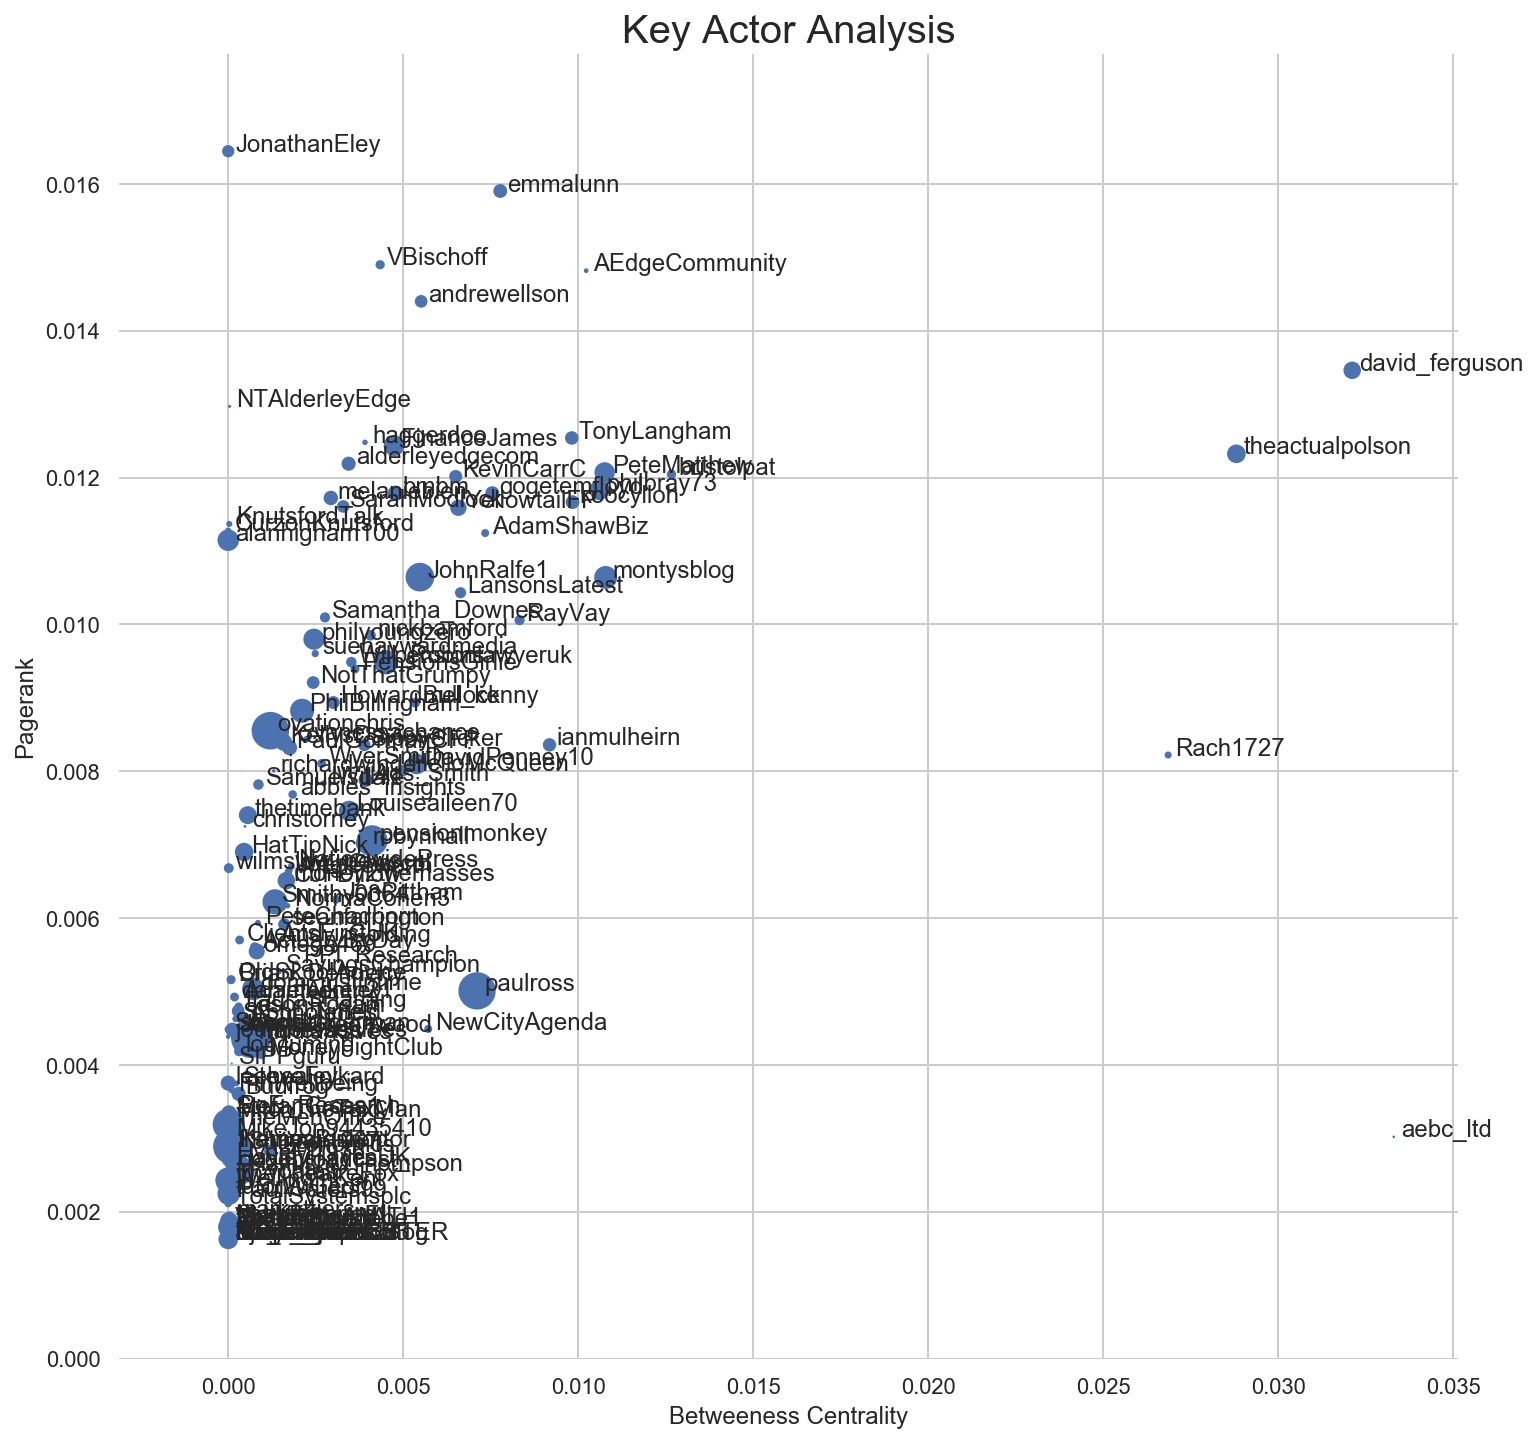

In [37]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(12, 12))
sns.despine(f, left=True, bottom=True)

sns.scatterplot(data=data_cq,
                x="bc", y="pr",
                size="statuses",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 400), linewidth=0,
                ax=ax, legend=False)
plt.title('Key Actor Analysis', fontsize=20)
# Set x-axis label
plt.xlabel('Betweeness Centrality')
# Set y-axis label
plt.ylabel('Pagerank')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.0002, point['y'], str(point['val']))

label_point(data_cq.bc, data_cq.pr, data_cq.handle, plt.gca())

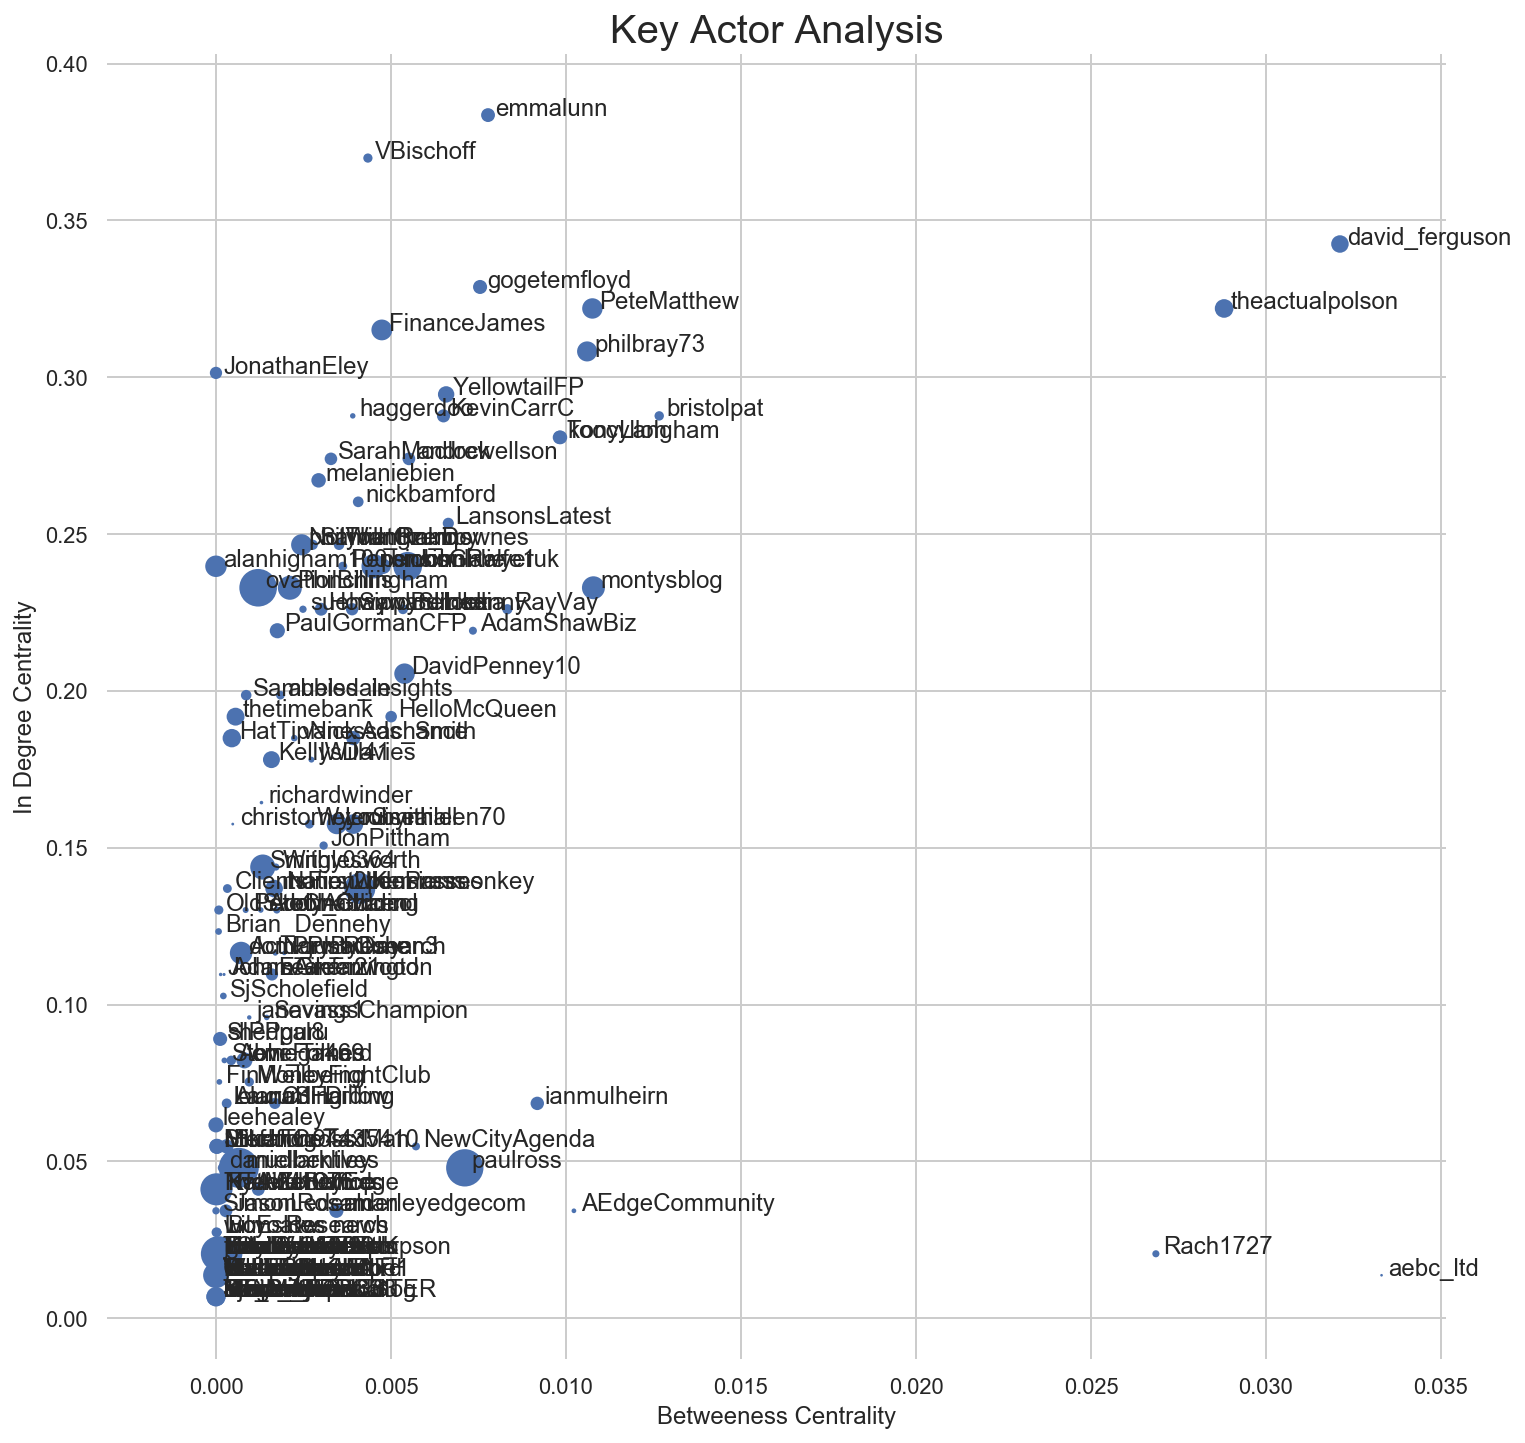

In [38]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(12, 12))
sns.despine(f, left=True, bottom=True)

sns.scatterplot(data=data_cq,
                x="bc", y="idc",
                size="statuses",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 400), linewidth=0,
                ax=ax, legend=False)
plt.title('Key Actor Analysis', fontsize=20)
# Set x-axis label
plt.xlabel('Betweeness Centrality')
# Set y-axis label
plt.ylabel('In Degree Centrality')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.0002, point['y'], str(point['val']))

label_point(data_cq.bc, data_cq.idc, data_cq.handle, plt.gca())